# Blood Donors

## Introduction

In this exercise, we will classify which blood donors are healthy so that we can take their blood donations.

As we have seen, stacking models together has potential in improving the learning process and reduce the variance. However, it hurts the interpretability of the models.

In this exercise we will be dealing with a very imbalanced dataset.

Our job is to create a model that can properly predict the blood donor category.

However, we are dealing with human life here, so we will need ot optimize our model to the fullest, and to supply interpretations to our predictions.

## Dataset

### Context
The data set contains laboratory values of blood donors and Hepatitis C patients and demographic values like age. The data was obtained from UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/HCV+data

### Content
All attributes except Category and Sex are numerical.
Attributes 1 to 4 refer to the data of the patient:
1. X (Patient ID/No.)
2. Category (diagnosis): '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'
3. Age (in years)
4. Sex (f,m)

Attributes 5 to 14 refer to laboratory data:
5. ALB
6. ALP
7. ALT
8. AST
9. BIL
10. CHE
11. CHOL
12. CREA
13. GGT
14. PROT

### Goal
The target attribute for classification is *Category* (2.): blood donors vs. Hepatitis C patients (including its progress - 'just' Hepatitis C, Fibrosis, Cirrhosis).

### Acknowledgements
Creators: Ralf Lichtinghagen, Frank Klawonn, Georg Hoffmann
Donor: Ralf Lichtinghagen: Institute of Clinical Chemistry; Medical University Hannover (MHH); Hannover, Germany; lichtinghagen.ralf '@' mh-hannover.de
Donor: Frank Klawonn; Helmholtz Centre for Infection Research; Braunschweig, Germany; frank.klawonn '@' helmholtz-hzi.de
Donor: Georg Hoffmann; Trillium GmbH; Grafrath, Germany; georg.hoffmann '@' trillium.de

### Relevant Papers
Lichtinghagen R et al. J Hepatol 2013; 59: 236-42
Hoffmann G et al. Using machine learning techniques to generate laboratory 
diagnostic pathways—a case study. J Lab Precis Med 2018; 3: 58-67


## Data preparation and examination

In [1]:
# Import the needed packages
import graphviz

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix

import xgboost as xgb

import seaborn as sns

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
# Load the data:
df = pd.read_csv('https://raw.githubusercontent.com/liadmagen/Modeling_course/main/data/HepatitisCdata.zip')

Let's look at our data:

Again - our goal is to correctly predict the Category

In [3]:
df

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,612,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,613,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,614,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,615.0,308.000000,177.679487,1.00,154.500,308.00,461.500,615.00
Age,615.0,47.408130,10.055105,19.00,39.000,47.00,54.000,77.00
ALB,614.0,41.620195,5.780629,14.90,38.800,41.95,45.200,82.20
ALP,597.0,68.283920,26.028315,11.30,52.500,66.20,80.100,416.60
ALT,614.0,28.450814,25.469689,0.90,16.400,23.00,33.075,325.30
AST,615.0,34.786341,33.090690,10.60,21.600,25.90,32.900,324.00
BIL,615.0,11.396748,19.673150,0.80,5.300,7.30,11.200,254.00
CHE,615.0,8.196634,2.205657,1.42,6.935,8.26,9.590,16.41
CHOL,605.0,5.368099,1.132728,1.43,4.610,5.30,6.060,9.67
CREA,615.0,81.287805,49.756166,8.00,67.000,77.00,88.000,1079.10


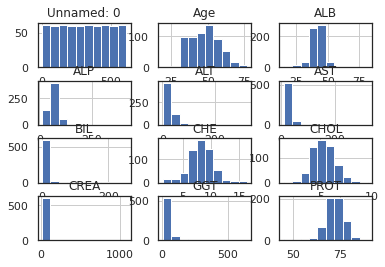

In [5]:
# And plotting histograms
hists = df.hist()

## Ensemble Models

Ensemble models are a machine learning approach to combine multiple other models in the prediction process. Those models are referred to as base estimators. It is a solution to overcome the frequent technical challenges of building a single estimator, such as:

High variance - when the model fits too much to the data
Low accuracy:  a single model might not be good enough for complex data.
Features noise and bias: the model may heavily rely on one or more features during inference.

### Bagging
Bagging is short for [Bootstrap Aggregating](https://en.wikipedia.org/wiki/Bootstrap_aggregating). It's a technique that is using bootstrapping (see below) to train several different models and aggregate their predictions.

Bootstrapping: Bagging is based on a bootstrapping sampling technique. Bootstrapping creates multiple sets of the original training data with replacement. Replacement enables the duplication of sample instances in the training subset. Each subset has the same size, and each is used to train a model in parallel.

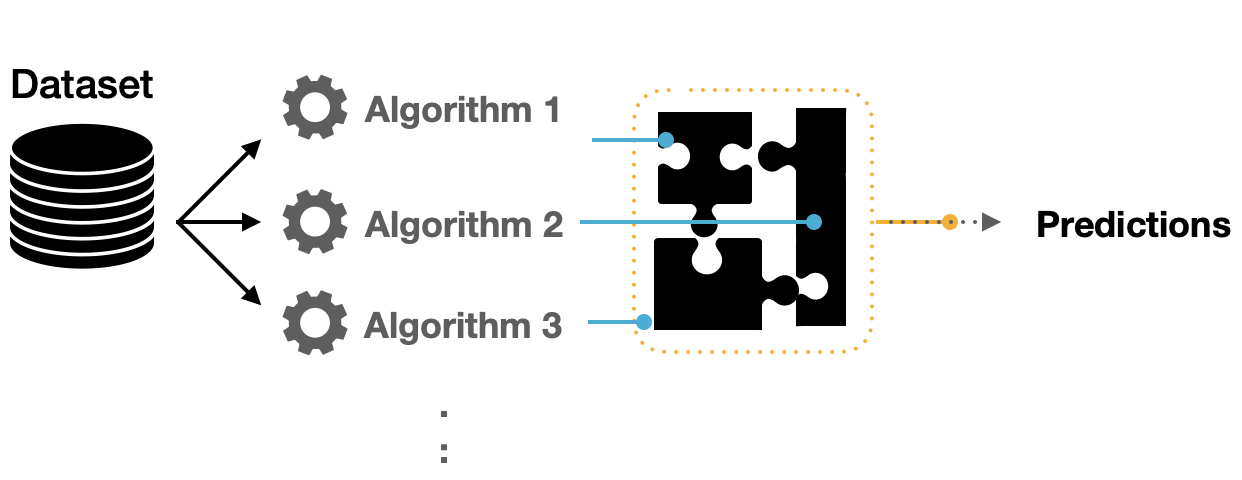

### Boosting
Boosting is a technique to reduce the bias from our models. It turns a set of 'weak learners' into a strong one. It is more sophisticated than Bagging (or at least more complicated), but not necessarily better. In every iteration, it adjusts a sample-related weight based on the observation of the previous classification.

More information about boosting is available on the XGBoost website:
https://xgboost.readthedocs.io/en/stable/tutorials/model.html#introduction-to-boosted-trees

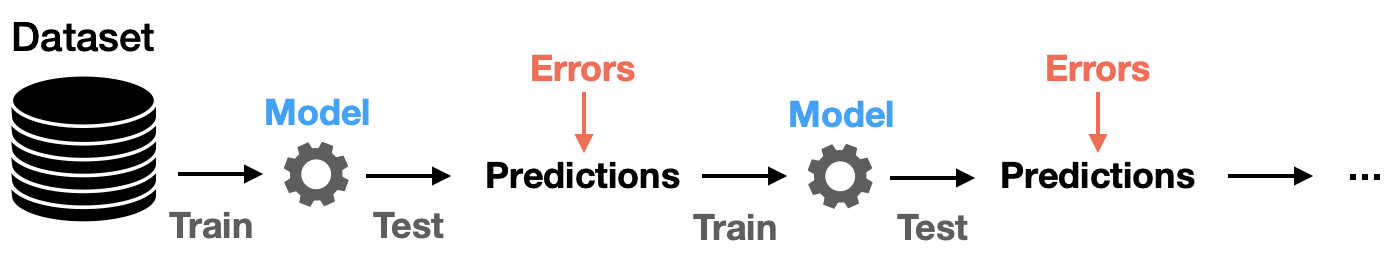


Both Bagging and Boosting are often referred to as meta-algorithms. It is a fancy way to say that this algorithm wraps some other algorithms or for a function that calls another function. In our case, it executes several other algorithms, such as decision trees, and aggregates their output. 


In [6]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [7]:
df['Category'].value_counts()

0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [8]:
df.columns

Index(['Unnamed: 0', 'Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST',
       'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

In [9]:
### Your turn ###
# Let's prepare our dataset.
# 1. We have an ID column ('unnamed: 0') which we should remove
# 2. We have a 'Category' column which is our target (label) column
# 3. One of our features is not numeric...
# 4. Some have NA...

# Note: Our dataset is VERY unbalanced (only 7 samples are 0s)
# Yet, we need to split it, but in a way that the label-distribution remains...


X = df.drop(['Unnamed: 0', 'Category'], axis=1)
X['Sex'] = X['Sex'].astype('category').cat.codes
y = df['Category'].astype('category')
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3,
                                                    stratify=y,
                                                    random_state=42)



##################

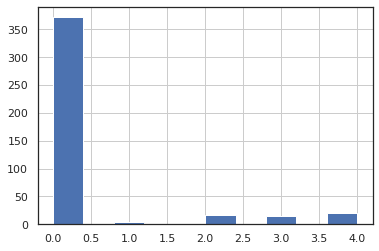

In [10]:
y_train.astype('category').cat.codes.hist()

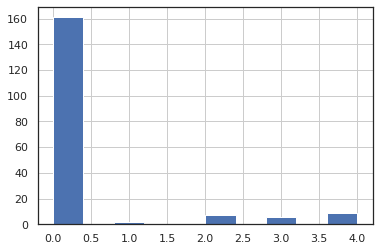

In [11]:
y_test.astype('category').cat.codes.hist()

In [12]:
def show_results(y_test, y_preds):
  """This method analyzies the classifier results. It:
  - prints the MCC score
  - prints a classification report 
  - prints a heatmap colored confusion matrix 
  """
  print(f'mcc score: {matthews_corrcoef(y_test, preds)}')
  print(classification_report(y_test, preds))

  conf_mat = confusion_matrix(y_test, y_preds) 
  label_names = df['Category'].astype('category').cat.categories
  df_cm = pd.DataFrame(conf_mat, label_names, label_names) 

  sns.set(font_scale=1.4) 
  sns.heatmap(df_cm, annot=True, fmt='d', cmap="YlGnBu")


Let's compare models.

1.   We start by creating a RandomForest classifier, and fitting it on our data.
2.   Then we create an ADABoost classifier, and fit it as well.




mcc score: 0.783010308138206
                        precision    recall  f1-score   support

         0=Blood Donor       0.98      1.00      0.99       161
0s=suspect Blood Donor       1.00      0.50      0.67         2
           1=Hepatitis       0.67      0.29      0.40         7
            2=Fibrosis       0.57      0.67      0.62         6
           3=Cirrhosis       0.89      0.89      0.89         9

              accuracy                           0.95       185
             macro avg       0.82      0.67      0.71       185
          weighted avg       0.95      0.95      0.95       185



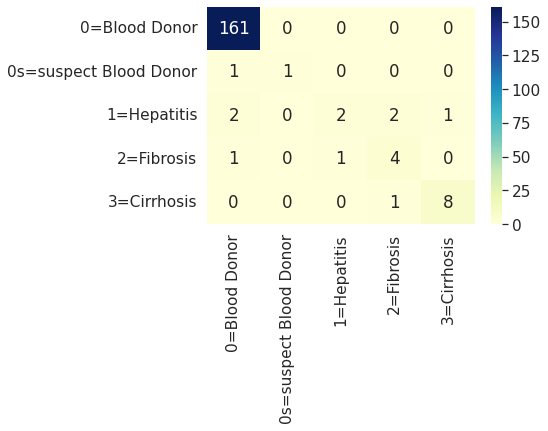

In [13]:
rfc = RandomForestClassifier()

### your turn ###
# train the model on the training set and predict on the test set.
# try running it several times (you will get different results)

rfc.fit(X_train, y_train)
preds = rfc.predict(X_test)


#######

show_results(y_test, preds) 


Now let's compare these results to the ADABoost:

mcc score: 0.6084797575140684
                        precision    recall  f1-score   support

         0=Blood Donor       0.96      0.99      0.98       161
0s=suspect Blood Donor       0.50      0.50      0.50         2
           1=Hepatitis       0.00      0.00      0.00         7
            2=Fibrosis       0.00      0.00      0.00         6
           3=Cirrhosis       0.47      0.89      0.62         9

              accuracy                           0.91       185
             macro avg       0.39      0.48      0.42       185
          weighted avg       0.87      0.91      0.89       185



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


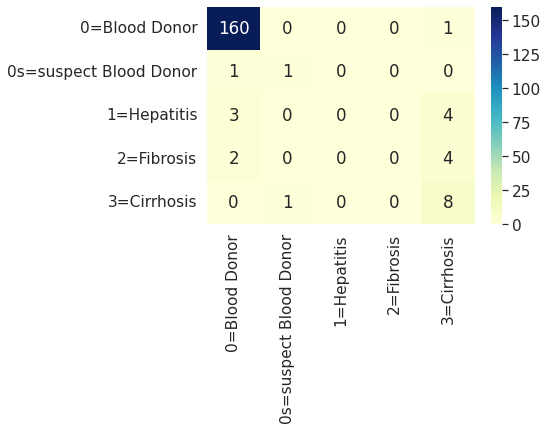

In [14]:
abc = AdaBoostClassifier()

### Your turn ###
# Train the AdaBoost (abc) on the training set
# make predictions on the test set

abc.fit(X_train, y_train)
preds = abc.predict(X_test)


##### 

show_results(y_test, preds) 


Notice the variations in the results when running it several times.

A common approach is to execute the model training several times and store the results of each run. In the end, one can select the model with the best score.

However, this result is partly due to the imbalanced classes in our dataset. So what can we do to overcome it?

## Imbalance Dataset

There are [several ways](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html) to approach the problem of imbalanced datasets. They include:

* Under-Sampling

  Under-sampling balances the dataset by reducing the size of the abundant class. This method is used when the quantity of data is sufficient. By keeping all samples in the rare class and randomly selecting an equal number of samples in the abundant class, a balanced new dataset can be retrieved for further modeling.

* Over-sampling

  On the contrary, oversampling is used when the quantity of data is insufficient. It tries to balance the dataset by increasing the size of rare samples - sampling more from those classes. Rather than getting rid of abundant samples, new rare samples are generated by using techniques such as sampling with repetition, bootstrapping, or [SMOTE](https://arxiv.org/abs/1106.1813)(Synthetic Minority Over-Sampling Technique).

Note that there is no absolute advantage of one resampling method over another. The application of these two methods depends on the use case it applies to and the dataset itself. A [combination](https://imbalanced-learn.org/stable/references/combine.html) of oversampling minority classes and undersampling the majority classes can be also successful.

* Ensemble models, Boosting and Bagging
  In ensemble classifiers, bagging methods build several estimators on different randomly selected subset of data. However, one should be careful with some of the bagging classifiers - as we are using from SKLearn, as they still tend to bias towards the magority class. 

The problem of imbalanced data is so prominant and crucial that specific [packages]((https://imbalanced-learn.org/stable/) are addressing it specifically. 


---

We will address it by using a specific hyperparameter of the RandomForrest - `class_weight`. There are two options: `balanced_subsample` or `balanced`.

Please refer to the documentation for more details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

mcc score: 0.7792414687132337
                        precision    recall  f1-score   support

         0=Blood Donor       0.96      1.00      0.98       161
0s=suspect Blood Donor       1.00      0.50      0.67         2
           1=Hepatitis       1.00      0.29      0.44         7
            2=Fibrosis       0.67      0.67      0.67         6
           3=Cirrhosis       0.89      0.89      0.89         9

              accuracy                           0.95       185
             macro avg       0.90      0.67      0.73       185
          weighted avg       0.95      0.95      0.94       185



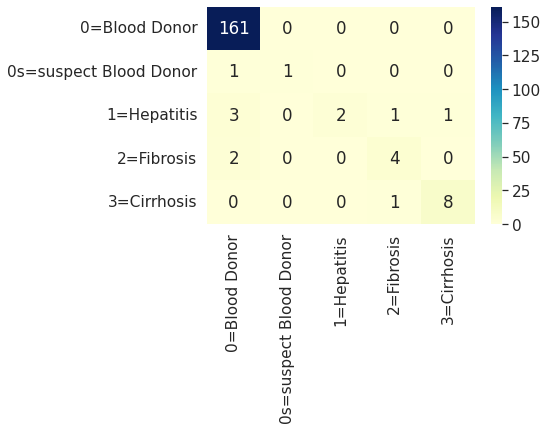

In [15]:
### Your turn ####
# Create and run the RandomForestClassifier again, but this time - set the 
# class_weight (parameter described above) to 'balanced'.

# How did it affect the results? Try running it few times to compare results.

# Now, try setting it to `balanced_subsample`
# How did it affect the results?

rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

########################

show_results(y_test, preds) 

Et voila. For the first time - we did not encounter errors of dividing by zero - meaning that our model finally classifies also the less-represented classes.

# XGBoost - “Extreme Gradient Boosting
XGBoost is one of the best algorithms we have at the moment.

It is composed of many tricks and methods that improve its performance computationally and improve the model accuracy metrics.

It is quite rich in capabilities, in models and in the ability to tune its hyperparameters.

The best place to learn about it is through the documentation:
https://xgboost.readthedocs.io/en/stable/tutorials/index.html#xgboost-tutorials

In [16]:
# First we need to prepare the data for XGBoost:
xgboost_train_data = xgb.DMatrix(X_train, label=y_train.astype('category').cat.codes)

mcc score: 0.788560582552298
                        precision    recall  f1-score   support

         0=Blood Donor       0.99      1.00      0.99       161
0s=suspect Blood Donor       1.00      0.50      0.67         2
           1=Hepatitis       0.50      0.29      0.36         7
            2=Fibrosis       0.57      0.67      0.62         6
           3=Cirrhosis       0.80      0.89      0.84         9

              accuracy                           0.95       185
             macro avg       0.77      0.67      0.70       185
          weighted avg       0.95      0.95      0.95       185



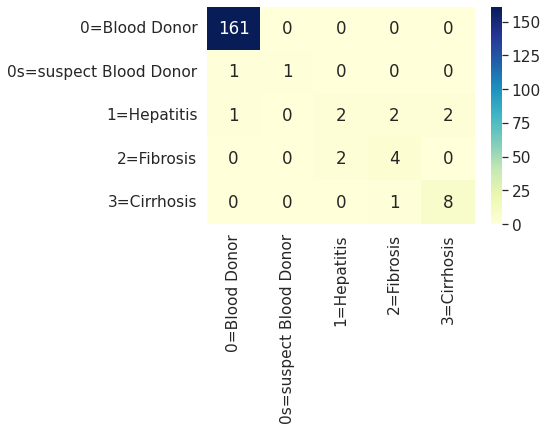

In [17]:
# XGBClassifier - XGB Classifier - a boosted ensemble of classifiers
reg = xgb.XGBClassifier()
xgb_clf = reg.fit(X_train, y_train)

preds = xgb_clf.predict(X_test)
show_results(y_test, preds) 

It seems like an improvement, right?

We still have one more model to check out - XGB also implements an improved version of Random Forest. Let's see how it does:

mcc score: 0.8101915558748382
                        precision    recall  f1-score   support

         0=Blood Donor       0.98      1.00      0.99       161
0s=suspect Blood Donor       1.00      0.50      0.67         2
           1=Hepatitis       0.67      0.29      0.40         7
            2=Fibrosis       0.62      0.83      0.71         6
           3=Cirrhosis       0.89      0.89      0.89         9

              accuracy                           0.96       185
             macro avg       0.83      0.70      0.73       185
          weighted avg       0.95      0.96      0.95       185



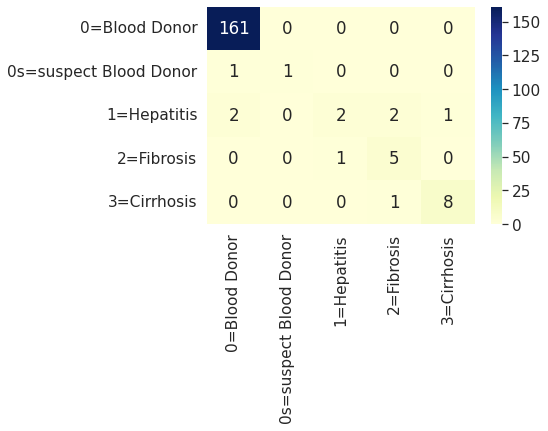

In [18]:
# XGBRFClassifier - XGB Random Forest Classifier
reg = xgb.XGBRFClassifier()
xgb_rf = reg.fit(X_train, y_train)

preds = xgb_rf.predict(X_test)
show_results(y_test, preds) 

Let's plot the underlying tree (although it's actually a forest)

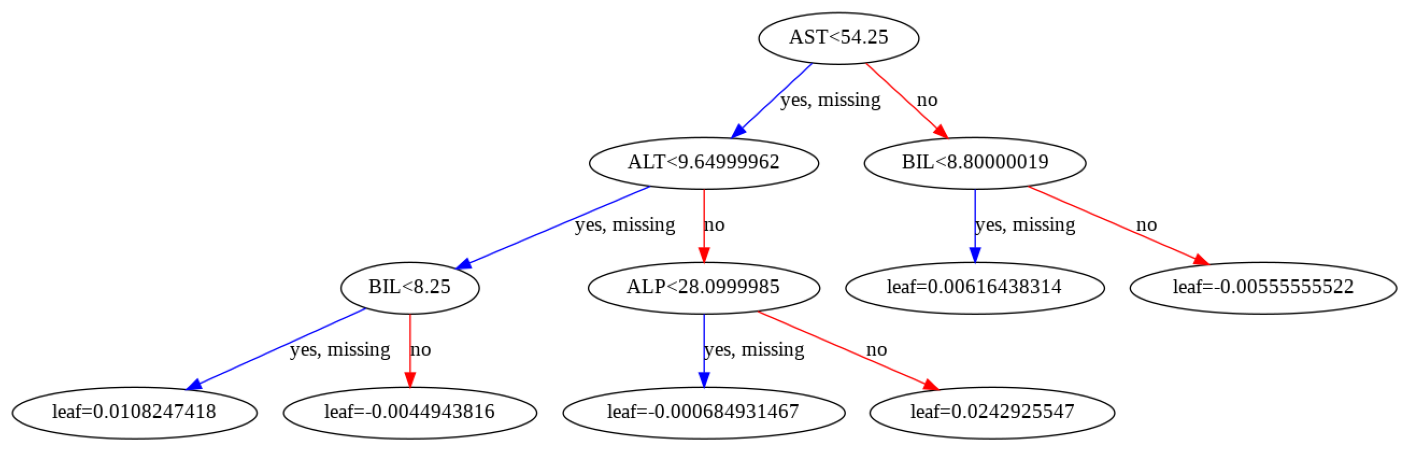

In [19]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(25,10))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_tree(xgb_rf, ax=ax, num_trees=9)


And the feature importance

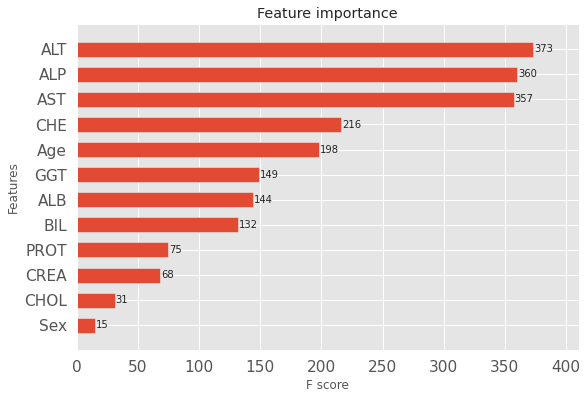

In [20]:
with plt.style.context("ggplot"):
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111)
    xgb.plotting.plot_importance(xgb_rf, ax=ax, height=0.6, importance_type="weight")


# SHAP

Shap is one of [several](https://github.com/jphall663/awesome-machine-learning-interpretability) existing techniques to explain the model predictions.



In [21]:
!pip install shap

In [22]:
import shap

We start by defining an explainer:


In [23]:
tree_explainer = shap.TreeExplainer(model=xgb_rf, data=X_train)

And calculating the shap values using the explainer

In [24]:
shap_vals = tree_explainer.shap_values(X_test.iloc[0]); shap_vals

[array([-6.71886580e-03,  2.07228581e-03,  1.40318488e-01,  3.30457988e-06,
         1.07499012e-01, -1.61115336e-01,  1.87560049e-02,  1.74129136e-02,
        -2.97874724e-04,  5.49567818e-03,  4.37069113e-02,  1.22441311e-02]),
 array([-0.00085119,  0.00119361,  0.18217706, -0.00802988,  0.07649578,
        -0.03183832,  0.04040889,  0.02221559,  0.00039284,  0.00559565,
         0.06216462,  0.00835146]),
 array([-0.00489687,  0.00308394,  0.19731273, -0.00055049,  0.20131178,
        -0.06098337,  0.01170925,  0.04341755,  0.00177977,  0.00327393,
         0.03261909, -0.01224639]),
 array([-0.00437668,  0.0012252 ,  0.18326535, -0.00431685,  0.14083272,
        -0.12375683,  0.02722345,  0.00706351, -0.0021366 , -0.00111941,
         0.11678343,  0.01311273]),
 array([-0.00179217, -0.00155199,  0.20236052,  0.00186057,  0.08598261,
        -0.08079989,  0.02387414,  0.04888429,  0.00336293,  0.00620445,
         0.01605172,  0.02100811])]

By default a SHAP bar plot will take the mean absolute value of each feature over all the instances (rows) of the dataset.

We will plot the feature importance again - but this time with relation to the predictions.

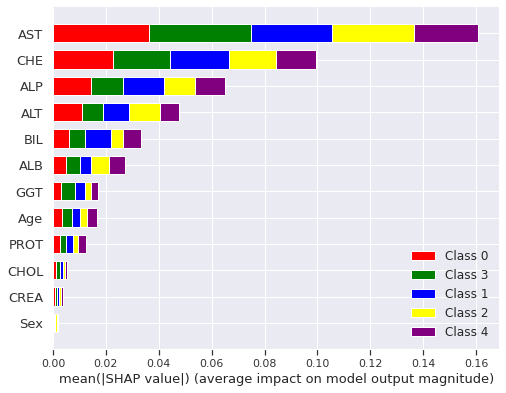

In [25]:
def get_col(i):
  colors = ['red', 'green', 'blue', 'yellow', 'purple']
  return colors[i]

shap.summary_plot(tree_explainer.shap_values(X_test),
                  feature_names=X_test.columns,                  
                  plot_type="bar",
                  color=get_col)



In [26]:
shap_values = tree_explainer(X_test); shap_values.shape

(185, 12, 5)

Let's scatter the data with regards to different attributes:

In [27]:
column_id_by_name= {k:i for i, k in enumerate(X.columns)}; column_id_by_name

{'ALB': 2,
 'ALP': 3,
 'ALT': 4,
 'AST': 5,
 'Age': 0,
 'BIL': 6,
 'CHE': 7,
 'CHOL': 8,
 'CREA': 9,
 'GGT': 10,
 'PROT': 11,
 'Sex': 1}

In [28]:
category_id_by_name =  {k:i for i, k in enumerate(y.cat.categories)}; category_id_by_name

{'0=Blood Donor': 0,
 '0s=suspect Blood Donor': 1,
 '1=Hepatitis': 2,
 '2=Fibrosis': 3,
 '3=Cirrhosis': 4}

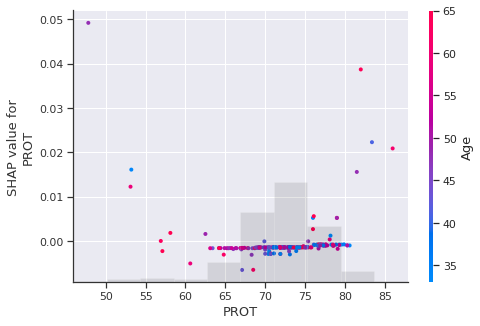

In [29]:
shap.plots.scatter(shap_values[:, column_id_by_name['PROT'], category_id_by_name['0=Blood Donor']], 
                   color=shap_values[:, column_id_by_name['Age'], category_id_by_name['0=Blood Donor']])

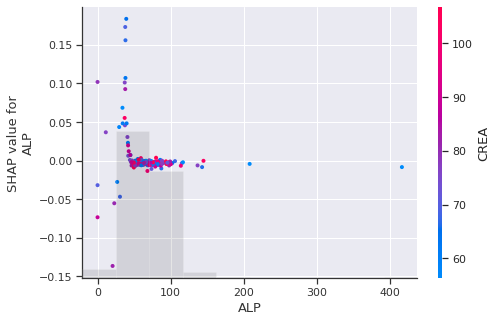

In [30]:
shap.plots.scatter(shap_values[:, column_id_by_name['ALP'], category_id_by_name['2=Fibrosis']], 
                   color=shap_values[:, column_id_by_name['CREA'], category_id_by_name['2=Fibrosis']])

Play around with SHAP yourself.

More info you can find here:

* https://github.com/slundberg/shap
* https://shap.readthedocs.io/en/latest/index.html
* https://coderzcolumn.com/tutorials/machine-learning/xgboost-an-in-depth-guide-python

In [31]:
### Your Playground - Feel free to add code cells ####




# Review previous datasets

Recall the datasets we were using during this course.

Let's revisit them using XGBoost and compare our results.

## Wine Dataset

On day I, we played with the wine-dataset and decision tree.

Our result were around 0.85% f-score

In [32]:
df_wine = pd.read_csv('https://raw.githubusercontent.com/liadmagen/Modeling_course/main/data/winequality-red.csv')

X_wine = df_wine.drop('quality', axis=1)
y_wine = df_wine['quality'] > 6.5

X_train, X_test, y_train, y_test = train_test_split(X_wine, 
                                                    y_wine, 
                                                    test_size=0.33,
                                                    stratify=y_wine, 
                                                    random_state=42)

In [33]:
### Your Turn ####
# Create a XGBoost Random Forest classifier and train it on the wine-data training-set
# generate predictions on the test set 

reg = xgb.XGBRFClassifier()
reg.fit(X_train, y_train)

preds = reg.predict(X_test)


###########################
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94       456
        True       0.83      0.28      0.42        72

    accuracy                           0.89       528
   macro avg       0.87      0.63      0.68       528
weighted avg       0.89      0.89      0.87       528

